## 목표
- 온도와 압력에 의한 패턴 분석 -> 고장 추세 예측
- 불량품 양품 예측

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

In [29]:
df = pd.read_csv('/disk2/output/input_61.csv')

## 데이터 형태(초기)
- (19429, 17)
- event_time: 제품에 레이저로 코드를 각인한 시각
- result: 양품=0, 불량품=1
- 1_1 : 온도_압력
- *온도(1 or 8), 압력(1 ~ 12)
- 각 행에 '리스트', 결국 str 형태로 총 601개의 값이 존재)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14706 entries, 0 to 14705
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  14706 non-null  object
 1   result      14706 non-null  int64 
 2   1_1         9247 non-null   object
 3   1_2         9244 non-null   object
 4   1_3         9247 non-null   object
 5   1_4         9246 non-null   object
 6   1_6         644 non-null    object
 7   1_7         2069 non-null   object
 8   1_8         8709 non-null   object
 9   1_9         8299 non-null   object
 10  1_10        885 non-null    object
 11  1_11        667 non-null    object
 12  1_12        6091 non-null   object
 13  8_1         9003 non-null   object
 14  8_2         8993 non-null   object
 15  8_3         8982 non-null   object
 16  8_4         9005 non-null   object
dtypes: int64(1), object(16)
memory usage: 1.9+ MB


In [31]:
df.shape

(14706, 17)

In [32]:
df.head()

,event_time,result,1_1,1_2,1_3,1_4,1_6,1_7,1_8,1_9,1_10,1_11,1_12,8_1,8_2,8_3,8_4
0,2022-09-22 03:18:00,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,2022-10-24 07:39:00,0,"[696.0, 696.0, 696.0, 696.0, 696.0, nan, 696.0...","[360.9, 360.9, 360.9, 360.9, 360.9, nan, 360.9...","[408.9, 408.9, 408.9, 408.9, 408.9, nan, 408.9...","[26.612, 26.612, 26.612, 26.612, 26.612, nan, ...",NaN,NaN,"[455.425, 455.425, 455.425, 455.425, 455.425, ...","[435.1, 435.1, 435.1, 435.1, 435.1, nan, 435.1...",NaN,NaN,"[357.275, 357.275, 357.275, 357.275, 357.275, ...",NaN,NaN,NaN,NaN
2,2022-09-20 23:35:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-04-11 21:06:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-27 02:22:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 전처리1. Null 제거
#### 열
- 과정 : nan으로 이루어진 열이라고 예상되는 값에 대해서 null값을 세어봄.
- 결과 : 총 5개의 열이 null로만 이루어진 값이기에 drop하여 (19429, 12)로 수정
#### 행
- 과정 : df[:,'1_1':'8_4']에 대해서 null이 10인 경우(event_time, result 제외) 행 drop
- 결과 : 6545개의 행이 null로만 이루어진 값이므로 제거하여 (12884, 12)로 수정

In [33]:
float_col = []
for col in ['1_4', '1_6', '1_7', '1_11', '1_12']:
    total_nan_values = df[col].isnull().sum().sum()
    print (total_nan_values, end = ', ')

5460, 14062, 12637, 14039, 8615, 

In [34]:
# df.drop(columns= ['1_4', '1_6', '1_7', '1_11', '1_12'], inplace=True)
df.shape

(14706, 17)

In [35]:
row_index = []
for i in range(0,len(df)):
    # print(df.loc[i, '1_1':'8_4'])
    total_nan_values = df.loc[i, '1_1':'8_4'].isnull().sum()
    # print(total_nan_values)
    if total_nan_values == 15:
        row_index.append(i)
print(len(row_index))
print(df.shape)

5459
(14706, 17)


In [36]:
for num in row_index:
    df.drop(index=num, axis=0, inplace=True)
print(df.shape)

(9247, 17)


In [37]:
# import ast
# import numpy as np

# # Assuming df is your DataFrame containing the data
# data_str = df.loc[7][2]

# # Replace NaN with None
# data_str_cleaned = str(data_str).replace('nan', 'None')

# # Use ast.literal_eval to safely evaluate the cleaned string
# data_list = ast.literal_eval(data_str_cleaned)

# # Convert None back to numpy NaN
# data_array = np.array(data_list)
# data_array[data_array == None] = np.nan

# print(data_array)


In [38]:
df.head()

,event_time,result,1_1,1_2,1_3,1_4,1_6,1_7,1_8,1_9,1_10,1_11,1_12,8_1,8_2,8_3,8_4
0,2022-09-22 03:18:00,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,2022-10-24 07:39:00,0,"[696.0, 696.0, 696.0, 696.0, 696.0, nan, 696.0...","[360.9, 360.9, 360.9, 360.9, 360.9, nan, 360.9...","[408.9, 408.9, 408.9, 408.9, 408.9, nan, 408.9...","[26.612, 26.612, 26.612, 26.612, 26.612, nan, ...",NaN,NaN,"[455.425, 455.425, 455.425, 455.425, 455.425, ...","[435.1, 435.1, 435.1, 435.1, 435.1, nan, 435.1...",NaN,NaN,"[357.275, 357.275, 357.275, 357.275, 357.275, ...",NaN,NaN,NaN,NaN
5,2023-02-20 20:41:00,0,"[692.0, nan, nan, nan, nan, nan, nan, nan, nan...","[360.4, nan, nan, nan, nan, nan, nan, nan, nan...","[396.2, nan, nan, nan, nan, nan, nan, nan, nan...","[8.741, nan, nan, nan, nan, nan, nan, nan, nan...",NaN,NaN,"[495.425, nan, nan, nan, nan, nan, nan, nan, n...","[473.5, nan, nan, nan, nan, nan, nan, nan, nan...",NaN,NaN,NaN,"[806.0, nan, nan, nan, nan, nan, nan, nan, nan...","[804.0, nan, nan, nan, nan, nan, nan, nan, nan...","[804.0, nan, nan, nan, nan, nan, nan, nan, nan...","[2.0, nan, nan, nan, nan, nan, nan, nan, nan, ..."
6,2022-09-08 11:12:00,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
7,2022-10-04 11:16:00,0,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",NaN,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."


## 전처리2. each 데이터(601개)처리
1. str -> list
2. nan -> 0
3. len(data) = 601개로 맞춤 (0으로 채우기)
4. event_time기준으로 index정리

In [39]:
df.columns

Index(['event_time', 'result', '1_1', '1_2', '1_3', '1_4', '1_6', '1_7', '1_8',
       '1_9', '1_10', '1_11', '1_12', '8_1', '8_2', '8_3', '8_4'],
      dtype='object')

In [44]:
# str-> list & 0 

def convert_str_to_array(data_str):
    # Handle string representations of lists with 'nan' values
    if isinstance(data_str, str):
        data_list = data_str.replace('[', '').replace(']', '').split(', ')
        data_list = [float(x) if x != 'nan' else np.nan for x in data_list]
        data_array = np.array(data_list)
    else:
        data_array = np.array(data_str)

    # Convert NaN values to 0
    data_array[np.isnan(data_array)] = 0

    return data_array

# Specify the columns you want to apply the conversion to
columns_to_convert = df.columns.to_list()[2:]
print(columns_to_convert)
# Apply the conversion to the specified columns for all rows
for col in columns_to_convert:
    df[col] = df[col].apply(convert_str_to_array)

# Print the updated DataFrame
df.head(2)


['1_1', '1_2', '1_3', '1_4', '1_6', '1_7', '1_8', '1_9', '1_10', '1_11', '1_12', '8_1', '8_2', '8_3', '8_4']


,event_time,result,1_1,1_2,1_3,1_4,1_6,1_7,1_8,1_9,1_10,1_11,1_12,8_1,8_2,8_3,8_4
0,2022-09-22 03:18:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2022-10-24 07:39:00,0,"[696.0, 696.0, 696.0, 696.0, 696.0, 0.0, 696.0...","[360.9, 360.9, 360.9, 360.9, 360.9, 0.0, 360.9...","[408.9, 408.9, 408.9, 408.9, 408.9, 0.0, 408.9...","[26.612, 26.612, 26.612, 26.612, 26.612, 0.0, ...",0.0,0.0,"[455.425, 455.425, 455.425, 455.425, 455.425, ...","[435.1, 435.1, 435.1, 435.1, 435.1, 0.0, 435.1...",0.0,0.0,"[357.275, 357.275, 357.275, 357.275, 357.275, ...",0.0,0.0,0.0,0.0


In [15]:
# # 2. nan -> 0

# # print(data_array_cleaned)
# def nan2zero(convert_data):
#     if isinstance(convert_data, float):  # If it's a single float value
#         return 0 if np.isnan(convert_data) else convert_data
#     else:  # If it's an array
#         data_array_float = convert_data.astype(float)
#         data_array_cleaned = np.nan_to_num(data_array_float, nan=0)
#         return data_array_cleaned
    
# columns_to_convert = ['1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']

# for col in columns_to_convert:
#     df[col] = df[col].apply(nan2zero)
    
# print('done')

In [45]:
# 3. len(data) = 601개로 맞춤 (0으로 채우기)

list_601 = [0.0] * 601
array_601 = np.array(list_601) 
# print(data_array_cleaned)
def arr_601(convert_data):
    if isinstance(convert_data, float):  # If it's a single float value
        return array_601  # Replace 0 with the predefined list 'list_601'
    else:
        return convert_data

for col in columns_to_convert:
    df[col] = df[col].apply(arr_601)
df.head(1)

,event_time,result,1_1,1_2,1_3,1_4,1_6,1_7,1_8,1_9,1_10,1_11,1_12,8_1,8_2,8_3,8_4
0,2022-09-22 03:18:00,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [17]:
for time in df['event_time']:
    new_time = pd.to_datetime(time)
    time = new_time
df.shape

(12884, 12)

In [18]:
# 4. event_time기준으로 index정리
df.sort_values(by='event_time', inplace=True)
df.reset_index(drop=True, inplace=True)
print(df.shape)
df.head(1)

(12884, 12)


,event_time,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,2022-08-10 04:35:00,0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 0.0...","[366.85, 366.85, 366.85, 366.85, 366.85, 366.8...","[396.6, 396.6, 396.7, 396.7, 396.7, 396.6, 0.0...","[497.425, 495.425, 495.425, 495.425, 495.425, ...","[504.1, 505.8, 505.5, 505.2, 504.8, 504.5, 0.0...","[379.2, 379.1, 378.8, 378.8, 378.6, 378.4, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


#### 최종 drop
- 리스트 요소가 601개가 아닌 경우 존재
- 총 304개로 삭제
- 최종 df.shape = (12850,12)

In [19]:
strange_indices = {}  # 각 열의 이상한 경우의 인덱스를 저장할 딕셔너리 초기화

strange_index = []
for j in range(2, 12):
  # 현재 열의 이상한 경우의 인덱스를 저장할 리스트 초기화
    for i in range(12884):
        ex = df.iloc[i][j]
        len_ex = len(ex)
        if j ==2: 
            if len_ex != 601:
                strange_index.append(i)
        if j != 2:  # 첫 번째 열 이후로는 이전 열의 이상한 인덱스에 현재 열의 이상한 인덱스를 추가
            if len_ex != 601:
                strange_index.append(i)
    # strange_indices[j] = list(set(strange_index))  # 이상한 경우의 인덱스를 딕셔너리에 저장
real_strange_index = list(set(strange_index))
print(real_strange_index)
print(len(real_strange_index))

for num in real_strange_index:
    df.drop(index=num, axis=0, inplace=True)
print(j,'열의 shape = ',df.shape)

[7169, 7170, 8201, 10761, 5646, 12818, 5651, 10772, 10773, 12819, 12820, 4120, 4121, 11801, 11802, 11294, 35, 36, 3110, 3111, 3112, 10282, 7214, 9263, 1584, 1585, 11314, 3123, 3635, 3636, 5686, 11316, 12850, 12347, 10812, 12348, 3653, 8263, 11335, 4173, 4174, 4175, 3152, 3153, 3154, 5712, 11346, 597, 598, 599, 5719, 8278, 11350, 11351, 6237, 6238, 2655, 4710, 8807, 3182, 3183, 3184, 3185, 3697, 11375, 8820, 11376, 12404, 8826, 123, 124, 3198, 1663, 1664, 1665, 1666, 8321, 8322, 6278, 6790, 5624, 5769, 6799, 3216, 10897, 11407, 11408, 5781, 2711, 11424, 11425, 5799, 9895, 8364, 11956, 10423, 8687, 3262, 8688, 5825, 8689, 12486, 12487, 7672, 8690, 7164, 721, 722, 5332, 5333, 7380, 5847, 10457, 8922, 8185, 8415, 9951, 5345, 5346, 5347, 5348, 5349, 1254, 1255, 3815, 3816, 6378, 6379, 8188, 2285, 7405, 8427, 8428, 10472, 9615, 12024, 250, 251, 6910, 2816, 2817, 3845, 775, 776, 777, 9991, 10504, 7482, 12553, 12554, 10000, 1809, 7483, 9489, 9490, 1813, 1814, 1815, 9491, 12567, 10011, 10012, 9

## 데이터 시각화
- 예상 : 불량품과 양품 사이 구분될 만한 특징이 있을 것
- 실제 : 양품사이에서도 각기 다른 추세를 보임 

601


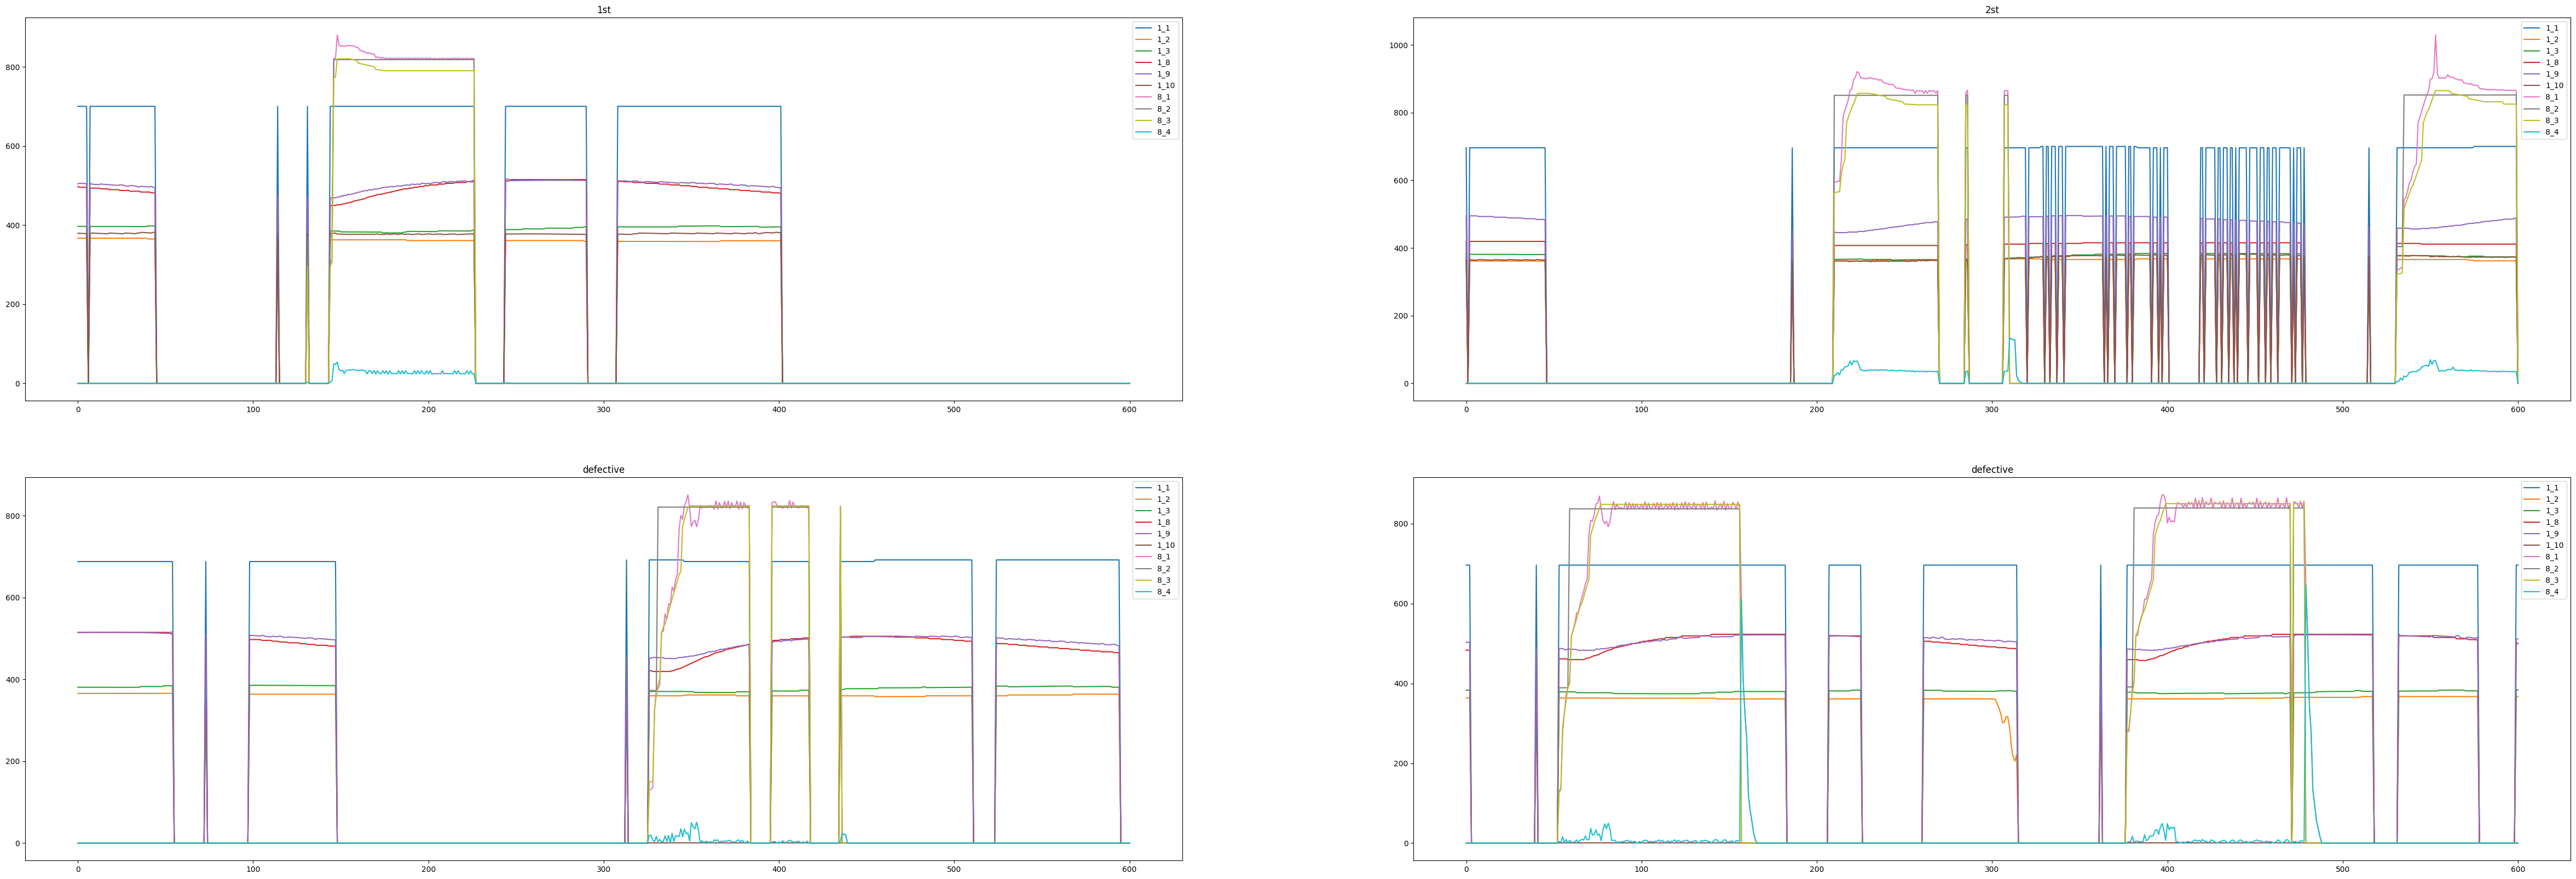

In [20]:
import matplotlib.pyplot as plt

x_time = []
for i in range(601):
    x_time.append(i)
print(len(x_time))

columns = ['1_1', '1_2', '1_3', '1_8', '1_9', '1_10', '8_1', '8_2', '8_3', '8_4']
plt.figure(figsize=(60,20))

plt.subplot(2, 2, 1)
for i in range(0,10) :
    y = df.loc[0][columns[i]]
    plt.plot(x_time, y, '-', label=columns[i]) 
plt.title('1st')
plt.legend()


# plt.figure(figsize=(15, 5))
plt.subplot(2, 2, 2)
for i in range(0,10) :
    y = df.loc[1][columns[i]]
    plt.plot(x_time, y, '-', label=columns[i])
plt.title('2st')
plt.legend()

# plt.figure(figsize=(15, 5))
plt.subplot(2, 2, 3)
for i in range(0,10) :
    y = df.loc[12872][columns[i]]
    plt.plot(x_time, y, '-', label=columns[i])
plt.title('defective')
plt.legend()


# plt.figure(figsize=(15, 5))
plt.subplot(2, 2, 4)
for i in range(0,10) :
    y = df.loc[12838][columns[i]]
    plt.plot(x_time, y, '-', label=columns[i])
plt.title('defective')
plt.legend()


## 데이터 전처리의 문제점
- 불량품과 양품 사이 구별할만한 뚜렷한 추세가 보이지 않음
- 최대최소 정규화(논문) 적용 불가능 -> 대신 정규화라도 해야하나

## 불균형 데이터
- 대락 5:1정도 

Index([0, 1], dtype='int64', name='result') [10250  2330]


<BarContainer object of 2 artists>

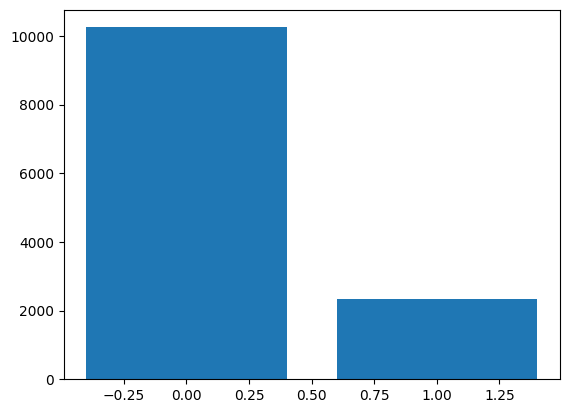

In [21]:
y_cla = df['result'].value_counts()
y_cla_ind = y_cla.index
y_cla_val = y_cla.values
print(y_cla_ind, y_cla_val)

plt.bar(y_cla_ind, y_cla_val)

# 최종데이터

In [22]:
df.head(1)

,event_time,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,2022-08-10 04:35:00,0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 0.0...","[366.85, 366.85, 366.85, 366.85, 366.85, 366.8...","[396.6, 396.6, 396.7, 396.7, 396.7, 396.6, 0.0...","[497.425, 495.425, 495.425, 495.425, 495.425, ...","[504.1, 505.8, 505.5, 505.2, 504.8, 504.5, 0.0...","[379.2, 379.1, 378.8, 378.8, 378.6, 378.4, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# df -> data

In [23]:
data = df.copy(deep=True)

In [24]:
data.shape

(12580, 12)

In [25]:
data.drop(columns = ['event_time'], inplace = True)
data.head(1)

,result,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 0.0...","[366.85, 366.85, 366.85, 366.85, 366.85, 366.8...","[396.6, 396.6, 396.7, 396.7, 396.7, 396.6, 0.0...","[497.425, 495.425, 495.425, 495.425, 495.425, ...","[504.1, 505.8, 505.5, 505.2, 504.8, 504.5, 0.0...","[379.2, 379.1, 378.8, 378.8, 378.6, 378.4, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


## 전처리3. 정규화
- df_trian, df_valid, df_test 총 3개로 나누어 진행

## 모델 LSTM-autoencoder
1. 데이터 로드 및 분할
2. 모델 설계
3. 모델 컴파일
4. 모델 학습
5. 모델 검증
6. 모델 테스트
7. 별과 분석 및 시각화
8. 모델 개선 및 튜닝

# 2023.08.18 분류 시도중
1. 데이터 셋

In [26]:
import copy

In [27]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
#정상 데이터셋 
normal_df = data[data.result == 0].drop(labels='result', axis=1)
normal_df.head(1)

,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
0,"[700.0, 700.0, 700.0, 700.0, 700.0, 700.0, 0.0...","[366.85, 366.85, 366.85, 366.85, 366.85, 366.8...","[396.6, 396.6, 396.7, 396.7, 396.7, 396.6, 0.0...","[497.425, 495.425, 495.425, 495.425, 495.425, ...","[504.1, 505.8, 505.5, 505.2, 504.8, 504.5, 0.0...","[379.2, 379.1, 378.8, 378.8, 378.6, 378.4, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [30]:
# 비정상 데이터셋
anomaly_df = data[data.result != 0].drop(labels='result', axis=1)
anomaly_df.shape

(2330, 10)

In [31]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 정상 -> train, val
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.25,
  random_state=RANDOM_SEED
)

# val -> val, test (with shuffle)
val_df, test_df = train_test_split(
  val_df,
  test_size=0.5,
  random_state=RANDOM_SEED,
  shuffle=True 
)

In [32]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(anomaly_df.shape)

(7687, 10)
(1281, 10)
(1282, 10)
(2330, 10)


In [33]:
train_df.head(2)

,1_1,1_2,1_3,1_8,1_9,1_10,8_1,8_2,8_3,8_4
4708,"[696.0, 696.0, 696.0, 696.0, 0.0, 696.0, 0.0, ...","[366.85, 366.85, 366.85, 366.85, 0.0, 366.85, ...","[390.5, 390.5, 390.5, 390.5, 0.0, 390.5, 0.0, ...","[526.85, 526.85, 526.85, 526.85, 0.0, 526.85, ...","[515.7, 515.7, 515.7, 515.5, 0.0, 515.4, 0.0, ...","[172.375, 172.375, 154.375, 155.4, 0.0, 194.4,...","[24.0, 24.0, 24.0, 24.0, 0.0, 24.0, 0.0, 24.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[24.0, 24.0, 24.0, 24.0, 0.0, 24.0, 0.0, 24.0,..."
5357,"[696.0, 696.0, 696.0, 696.0, 696.0, 696.0, 696...","[366.6, 366.6, 366.6, 366.6, 366.6, 366.6, 366...","[381.0, 381.1, 381.1, 381.2, 381.2, 381.3, 381...","[507.425, 507.425, 507.425, 507.425, 507.425, ...","[431.0, 431.0, 431.0, 431.0, 431.1, 431.1, 431...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23.0, 23...."


In [34]:
# def create_dataset(df):
#   sequences = df.astype(np.float32).to_numpy().tolist()
#   dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
#   n_seq, seq_len, n_features = torch.stack(dataset).shape
#   return dataset, seq_len, n_features

In [35]:
# train_dataset, seq_len, n_features = create_dataset(train_df)
# val_dataset, _, _ = create_dataset(val_df)
# test_normal_dataset, _, _ = create_dataset(test_df)
# test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [36]:
# dataset -> 3D
def temporalize_and_normalize(XX):
    X = []
    scaler = MinMaxScaler()
    for i in range(XX.shape[0]):
        end = []
        for j in range(0, 601):
            st = []
            for t in range(0, 10):
                zero = XX[i, t][j]
                st.append(zero)
            end.append(st)
        X.append(end)
    
    # Convert to numpy arrays
    X = np.array(X)
    
    # Reshape to 2D and normalize
    X_2d = X.reshape(-1, X.shape[-1])
    X_normalized_2d = scaler.fit_transform(X_2d)
    
    # Reshape back to 3D
    X_normalized = X_normalized_2d.reshape(X.shape)
    
    return X_normalized

train_df_normalized_3D = temporalize_and_normalize(train_df.values)
val_df_normalized_3D = temporalize_and_normalize(val_df.values)
test_df_normalized_3D = temporalize_and_normalize(test_df.values)
anomaly_df_normalized_3D = temporalize_and_normalize(anomaly_df.values)

print("train_df_normalized_3D: ", train_df_normalized_3D.shape)
print("val_df_normalized_3D: ", val_df_normalized_3D.shape)
print("test_df_normalized_3D: ", test_df_normalized_3D.shape)
print("anomaly_df_normalized_3D: ", anomaly_df_normalized_3D.shape)

train_df_normalized_3D:  (7687, 601, 10)
val_df_normalized_3D:  (1281, 601, 10)
test_df_normalized_3D:  (1282, 601, 10)
anomaly_df_normalized_3D:  (2330, 601, 10)


In [37]:
# 3D -> tensor
def create_dataset(data):
    dataset = [torch.tensor(seq, dtype=torch.float32) for seq in data]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features
    
train_dataset, seq_len, n_features = create_dataset(train_df_normalized_3D)
val_dataset, _, _ = create_dataset(val_df_normalized_3D)
test_normal_dataset, _, _ = create_dataset(test_df_normalized_3D)
test_anomaly_dataset, _, _ = create_dataset(anomaly_df_normalized_3D)
print(len(train_dataset))
print(len(train_dataset[0]))
print(len(train_dataset[0][1]))

7687
601
10


In [38]:
print(len(val_dataset))
print(len(val_dataset[0]))
print(len(val_dataset[0][1]))

1281
601
10


In [39]:
print(len(test_normal_dataset))
print(len(test_normal_dataset[0]))
print(len(test_normal_dataset[0][1]))

1282
601
10


# LSTM Autoencoder

In [40]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, embedding_dim
        self.rnn1 = nn.LSTM(
            input_size=n_features,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        
    def forward(self, x):
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n

In [41]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=10):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = input_dim, n_features  # hidden_dim을 input_dim으로 수정
        self.rnn1 = nn.LSTM(
            input_size=input_dim,
            hidden_size=self.hidden_dim,
            num_layers=2,
            batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, self.n_features)
        
    def forward(self, x):
        batch_size = x.size(0)
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.view(batch_size * self.seq_len, self.hidden_dim)
        x = self.output_layer(x)
        x = x.view(batch_size, self.seq_len, self.n_features)
        return x


In [42]:
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=32):
        super(RecurrentAutoencoder, self).__init__()
        self.seq_len = seq_len
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, self.seq_len, -1)  # Reshape the input
        x = self.encoder(x)
        x = x.repeat(1, self.seq_len, 1)
        x = self.decoder(x)
        return x

model = RecurrentAutoencoder(seq_len, n_features, 128)

In [43]:
print(model)

RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(10, 128, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(128, 128, num_layers=2, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [102]:
def train_model(model, train_dataset, val_dataset, n_epochs):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.L1Loss()
    history = dict(train=[], val=[])
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    
    for epoch in range(1, n_epochs + 1):
        model = model.train()
        train_losses = []
        for seq_true in tqdm(train_dataset, desc=f'Epoch {epoch}'):
            optimizer.zero_grad()
            seq_true = seq_true.view(-1, seq_len, n_features)
            seq_pred = model(seq_true)
            seq_pred = seq_pred.view(-1, seq_len, n_features)
            
            loss = criterion(seq_pred, seq_true)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for seq_true in tqdm(val_dataset, desc=f'Epoch {epoch} (Validation)'):
                seq_true = seq_true.view(-1, seq_len, n_features)  # Reshape the input
                seq_pred = model(seq_true)
                seq_pred = seq_pred.view(-1, seq_len, n_features)
                
                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())
        
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train'].append(train_loss)
        history['val'].append(val_loss)
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
    
    model.load_state_dict(best_model_wts)
    return model.eval(), history

model, history = train_model(
    model,
    train_dataset,
    val_dataset,
    n_epochs=1
)

Epoch 1 (Validation): 100%|██████████| 1281/1281 [00:54<00:00, 23.64it/s]

Epoch 1: train loss 0.19946473283072635 val loss 0.23484420355272703


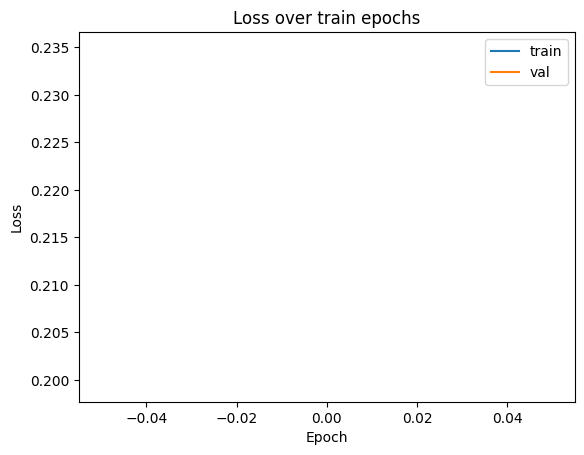

In [103]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.xlabel('Epoch')        
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.title('Loss over train epochs')
plt.show()

In [104]:
train_loss = history['train']
val_loss = history['val']

print("Training Loss:", train_loss)
print("Validation Loss:", val_loss)

Training Loss: [0.19946473283072635]
Validation Loss: [0.23484420355272703]


In [105]:
MODEL_PATH = 'model.pth'
torch.save(model.state_dict(), MODEL_PATH)

In [106]:
import torch

def predict(model, dataset, seq_len, n_features):
    predictions, losses = [], []
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_true = seq_true.view(-1, seq_len, n_features)
            seq_pred = model(seq_true)
            squared_errors = (seq_pred - seq_true) ** 2  # Calculate squared errors
            loss = torch.mean(squared_errors)  # Calculate MSE
            predictions.append(seq_pred.cpu().numpy().flatten())
            losses.append(loss.item())
    return predictions, losses


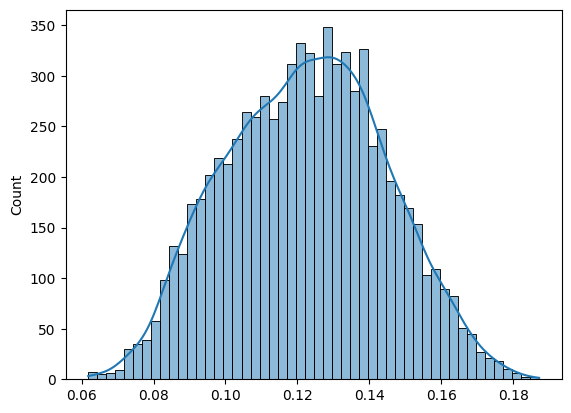

In [107]:
_, losses = predict(model, train_dataset, seq_len, n_features)


import seaborn as sns
sns.histplot(losses, bins=50, kde=True);

## Evaluation
### Normal 

In [121]:
THRESHOLD = 0.2

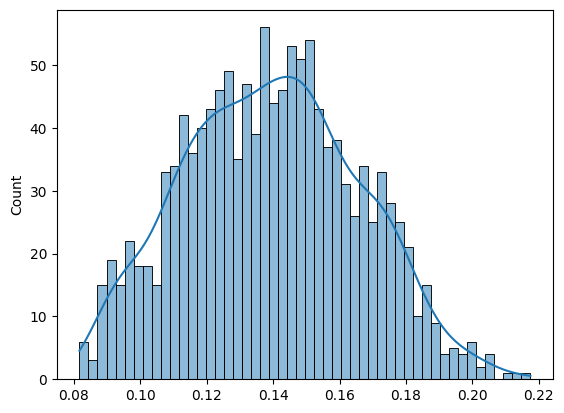

In [128]:
normal_predictions, normal_pred_losses = predict(model, test_normal_dataset, seq_len, n_features)
sns.histplot(normal_pred_losses, bins=50, kde=True);

In [130]:
print(len(normal_pred_losses))

1282


In [124]:
correct = sum(l <= THRESHOLD for l in normal_pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

Correct normal predictions: 1271/1282


### anomal

In [125]:
# anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]
anomaly_dataset = test_anomaly_dataset

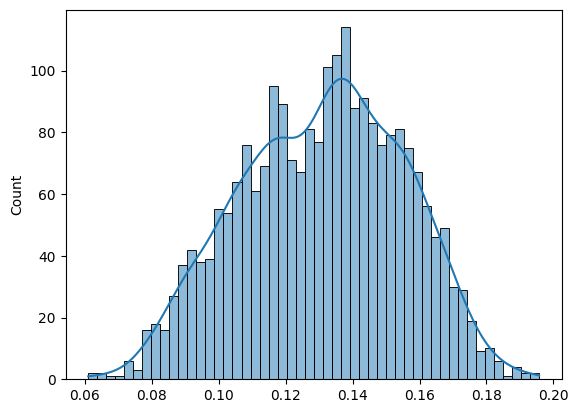

In [129]:
anomaly_predictions, anomaly_pred_losses = predict(model, anomaly_dataset,  seq_len, n_features)
sns.histplot(anomaly_pred_losses, bins=50, kde=True);

In [127]:
correct = sum(i > THRESHOLD for i in anomaly_pred_losses)
print(f'Correct anomaly predicitons: {correct}/{len(anomaly_dataset)}')

Correct anomaly predicitons: 0/2330


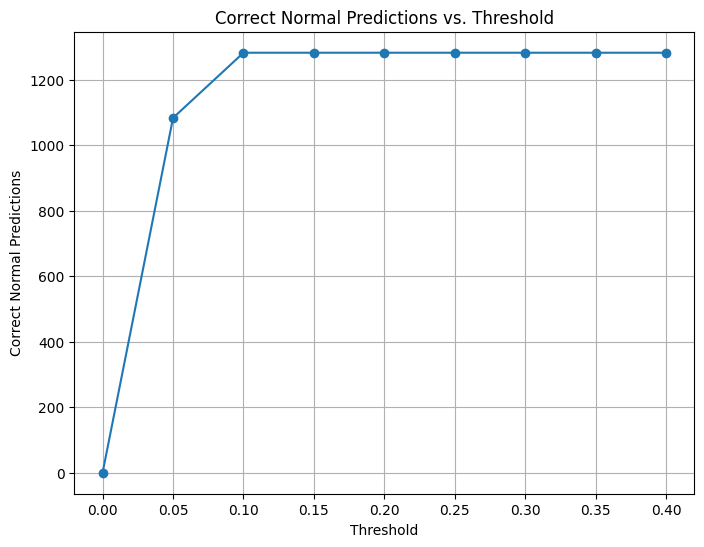

In [216]:
import numpy as np
import matplotlib.pyplot as plt

# Threshold 범위 설정
thresholds = np.arange(0.0, 0.41, 0.05)

# 결과 저장용 리스트
normal_correct_values = []

# 모델의 예측과 손실 계산
predictions, pred_losses = predict(model, test_normal_dataset, seq_len, n_features)

# 각 threshold 값에 대한 normal_correct 계산
for threshold in thresholds:
    normal_correct = sum(loss <= threshold for loss in pred_losses)
    normal_correct_values.append(normal_correct)

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(thresholds, normal_correct_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Correct Normal Predictions')
plt.title('Correct Normal Predictions vs. Threshold')
plt.grid()
plt.show()


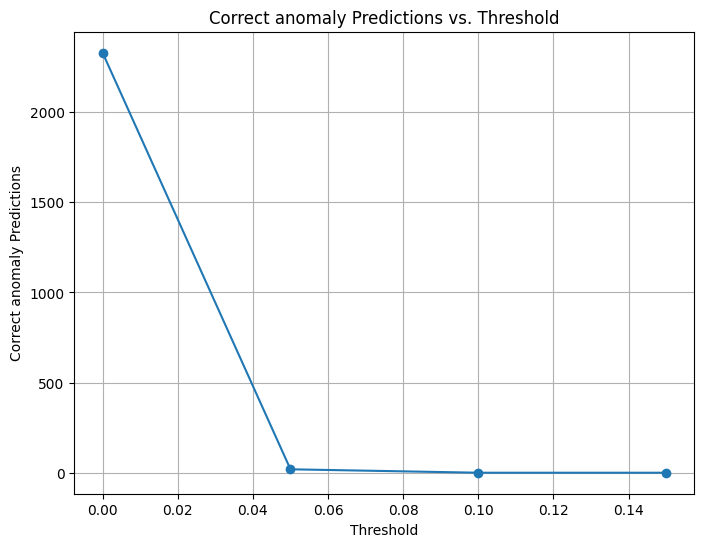

In [219]:
import numpy as np
import matplotlib.pyplot as plt

# Threshold 범위 설정
thresholds = np.arange(0.0, 0.2, 0.05)

# 결과 저장용 리스트
anomaly_correct_values = []

# 모델의 예측과 손실 계산
predictions, pred_losses = predict(model, anomaly_dataset, seq_len, n_features)

# 각 threshold 값에 대한 normal_correct 계산
for threshold in thresholds:
    anomaly_correct = sum(loss > threshold for loss in pred_losses)
    anomaly_correct_values.append(anomaly_correct)

# 시각화
plt.figure(figsize=(8, 6))
plt.plot(thresholds, anomaly_correct_values, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Correct anomaly Predictions')
plt.title('Correct anomaly Predictions vs. Threshold')
plt.grid()
plt.show()
